Code to test the precision of the end point with dmp and cvae

In [53]:
import os, time, tqdm, sys
import torch.nn as nn
import numpy as np
import torch

# add parent dictionary to path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from models.vae import TrajGen, DM
from models.dmp import CanonicalSystem, SingleDMP
from utils.data_loader import TorqueLoader as Torque_dataset
from utils.early_stop import EarlyStop
from matplotlib import pyplot as plt
from collections import OrderedDict
print(os.getcwd())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/binzhao/Documents/code/VAE_DMP_mani/number_write_task


In [54]:
# load the data set and the class to normalize the data
# denormalize the torque0.0012    & 0.0116 
run_time = 1
dt = 0.01
shape = (2, 100)
# create dataset for training and testing
cs = CanonicalSystem(dt=0.01, ax=1)
dmp = SingleDMP(n_bfs=50, cs=cs, run_time=1.0, dt=0.01)


train_dataset = Torque_dataset(run_time=1, dmp=dmp, dt=0.01, dof=2)
train_dataset.load_data('../data/number_write/train_torque.npz', device=device)
train_dataset.torque = train_dataset.normalize_data(device=device)

#get normalize  paramters of data
max = train_dataset.max.cpu().numpy()
min = train_dataset.min.cpu().numpy()
print(max, min)

[178.56984 199.07835] [-187.85435 -179.23535]


load the pretrain torque based trajectory generator (cVAE based)

In [55]:
# load the pretrained model
save_name = "cVAE_torque.pt"
checkpoint = torch.load(save_name, map_location=device)
dict = checkpoint['net']

/tmp/ipykernel_50951/1858532253.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_name, map_location=device)


In [56]:
# load the decoder part only -- generator
decoder_param = OrderedDict() 
    
key_word_1 = {"decoder."}
key_word_2 = {"label_embedding."}

for layer_name, param in checkpoint["net"].items():
    for key_word in key_word_1:
        if key_word in layer_name:            
            layer_name = layer_name.replace(key_word, "")            
            decoder_param[layer_name] = param

torch.save(decoder_param, "../models/decoder.pt")

# save label encoder
label_encoder_param = OrderedDict()
for layer_name, param in checkpoint["net"].items():
    for key_word in key_word_2:
        if key_word in layer_name:            
            layer_name = layer_name.replace(key_word, "")            
            label_encoder_param[layer_name] = param

torch.save(label_encoder_param, "../models/label_encoder.pt")

create trajecotr generator  --  decoder + dynamics systems

In [57]:
shape = (2, 100)
nclass=10
nhid=8
ncond=8
traj_gen = TrajGen(shape=shape, nclass=nclass, nhid=nhid, ncond=ncond, min=min, max=max, device=device)
# send to device
traj_gen = traj_gen.to(device)
# load model
traj_gen.decoder_o.load_state_dict(torch.load('../models/decoder.pt'))
traj_gen.decoder_n.load_state_dict(torch.load('../models/decoder.pt'))
traj_gen.label_embedding.load_state_dict(torch.load('../models/label_encoder.pt'))

/tmp/ipykernel_50951/2391882050.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  traj_gen.decoder_o.load_state_dict(torch.load('../models/decoder.pt'))
/tmp/ipykernel_509

<All keys matched successfully>

In [58]:
# create a data set for the cVAE testing
start = np.array([0, 1])
ends = np.array([1, 0])
end_range = 0.3
end_offset = 0

numbers_dict = [1, 2, 3, 6, 7]
aug_number = 2000
train_dataset = []
train_labels = []

# generate the data set
for number in numbers_dict:
    for i in range(aug_number):
        end = ends + end_range * (np.random.rand(2) - 0.5) + end_offset

        traj_gen.eval()
        with torch.no_grad():
            data = traj_gen(number, x0=start, goal=end)
        traj = data.detach().cpu().numpy()[0, :, :]        
        labels = np.concatenate((np.array([numbers_dict.index(number)]), traj[:,0], traj[:, -1]))
        train_dataset.append(traj)
        train_labels.append(labels)     

10000


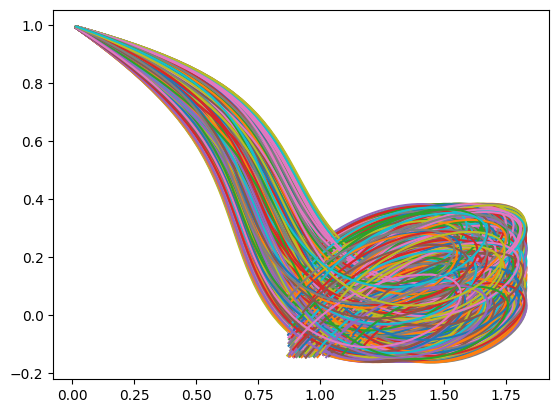

In [64]:
print(len(train_dataset))
# plot the data in the train_dataset
plt.figure()
for traj, labels in zip(train_dataset, train_labels):    
    if labels[0] == 3:
        plt.plot(traj[0, :], traj[1, :])

In [65]:
file_name = f"test_traj_{aug_number}.npz"
# save the data set
np.savez("../data/number_write/cVAE_dataset/" + file_name, train_dataset=train_dataset, labels=train_labels)

In [66]:
train_data = np.load("../data/number_write/cVAE_dataset/" + file_name)
print(train_data['train_dataset'].shape)
print(train_data['labels'].shape)

(10000, 2, 100)
(10000, 5)


In [83]:
# a data loader for the cVAE
import torch
from torch.utils.data import Dataset, DataLoader

class cVAE_loader(Dataset):
    def __init__(self, file_name, device):
        data = np.load(file_name)
        self.data = data['train_dataset']        
        self.labels = data['labels']
        self.device = device

    def __len__(self):
        return len(self.data)
    
    def nomalize_data(self):
        max = np.max(self.data, axis=(0, 2), keepdims=True)
        min = np.min(self.data, axis=(0, 2), keepdims=True)
        self.data = (self.data - min) / (max - min)
        self.max = max
        self.min = min

    def denormalize_data(self, traj):
        return traj * (self.max - self.min) + self.min

    def __getitem__(self, idx):
        traj = self.data[idx]
        traj = torch.tensor(traj, dtype=torch.float32).to(self.device)
        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.float32).to(self.device)
        return traj, label

In [84]:
# train the cVAE model
train_dataset = cVAE_loader("../data/number_write/cVAE_dataset/"+file_name, device=device)
train_dataset.nomalize_data()

train_iter = DataLoader(train_dataset, batch_size=64, shuffle=True)

# check the data
for traj, label in train_iter:
    print(f"Trajectory shape: {traj.shape}")  # Expected: (batch_size, feature_dim)
    print(f"Label shape: {label.shape}")  # Expected: (batch_size,)
    break  # Stop after first batch

Trajectory shape: torch.Size([64, 2, 100])
Label shape: torch.Size([64, 5])


In [87]:
# the 1D cVAE model
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)


class MLP(nn.Module):
    def __init__(self, hidden_size, last_activation=True):
        super(MLP, self).__init__()
        q = []
        for i in range(len(hidden_size)-1):
            in_dim = hidden_size[i]
            out_dim = hidden_size[i+1]
            q.append(("Linear_%d" % i, nn.Linear(in_dim, out_dim)))
            if (i < len(hidden_size)-2) or ((i == len(hidden_size) - 2) and (last_activation)):
                # q.append(("BatchNorm_%d" % i, nn.BatchNorm1d(out_dim)))
                q.append(("ReLU_%d" % i, nn.ReLU(inplace=True)))
        self.mlp = nn.Sequential(OrderedDict(q))

    def forward(self, x):
        return self.mlp(x)


class Encoder(nn.Module):
    def __init__(self, shape, nhid=4, ncond=0):
        """
        the shape of input data -- (ndof, time_steps)
        """
        super(Encoder, self).__init__()
        self.n_dof, self.time_steps = shape
        # calculate the shape of the output of the encoder
        ww = ((self.time_steps - 5) // 2 + 1)
        ww = ((ww - 5) // 2 + 1) // 2
        ww = ((ww - 3) // 2 + 1)
        ww = ((ww - 3) // 2 + 1) // 2

        self.encode = nn.Sequential(nn.Conv1d(self.n_dof, 16, 5, stride=2, padding=0), nn.BatchNorm1d(16), nn.ReLU(inplace=True),
                                    nn.Conv1d(16, 32, 5, stride=2, padding=0), nn.BatchNorm1d(32), nn.ReLU(inplace=True),
                                    nn.MaxPool1d(2),
                                    nn.Conv1d(32, 64, 3, stride=2, padding=0), nn.BatchNorm1d(64), nn.ReLU(inplace=True),
                                    nn.Conv1d(64, 64, 3, stride=2, padding=0), nn.BatchNorm1d(64), nn.ReLU(inplace=True),
                                    nn.MaxPool1d(2),
                                    Flatten(), MLP([ww*64, self.n_dof*32]))

        self.calc_mean = MLP([32*self.n_dof+ncond, 16*self.n_dof, nhid*self.n_dof], last_activation=False)
        self.calc_logvar = MLP([32*self.n_dof+ncond, 16*self.n_dof, nhid*self.n_dof], last_activation=False)

    def forward(self, x, y):
        """
        :param x: (batch_size, n_dof, time_steps)
        :param y: (batch_size, ncond)  -- condition 
        """
        x = self.encode(x)
        mean = self.calc_mean(torch.cat((x, y), dim=1))
        logvar = self.calc_logvar(torch.cat((x, y), dim=1))

        return mean, logvar


class Decoder(nn.Module):
    def __init__(self, shape, nhid=8, ncond=0):
        super(Decoder, self).__init__()
        self.n_dof, self.time_steps = shape
        self.shape = shape
        self.decode = nn.Sequential(MLP([nhid*self.n_dof+ncond, 64, 128, self.time_steps*self.n_dof],
                                        last_activation=False), nn.Sigmoid())

    def forward(self, z, y=None):
        c, w = self.shape
        if (y is None):
            return self.decode(z).view(-1, c, w)
        else:
            return self.decode(torch.cat((z, y), dim=1)).view(-1, c, w)


class CVAE(nn.Module):
    def __init__(self, shape, nclass, npos, nhid=8, ncond=4):
        """
        :param shape: the shape of the input data
        :param nclass: the number of classes
        :param condition: the number of condition: end position
        """
        super(CVAE, self).__init__()
        self.n_dof, self.time_steps = shape
        self.dim = self.n_dof * nhid
        self.encoder = Encoder(shape, nhid, ncond+npos)
        self.decoder = Decoder(shape, nhid, ncond + npos)
        
        self.label_embedding = nn.Embedding(nclass, ncond)  
        self.mse_loss = nn.MSELoss()

    def forward(self, x, y=None):

        label = y[:, 0].to(dtype=torch.int)
        position = y[:, 1:]
        label_emb = self.label_embedding(label)
        em_condit = torch.cat([label_emb, position], dim=1)


        mean, logvar = self.encoder(x, em_condit)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decoder(z, em_condit)
        return x_hat, mean, logvar

    def reparameterize(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        sigma = 0.5 * torch.exp(logvar)
        return mean + eps * sigma

    def loss(self, X, X_hat, mean, logvar):
        reconstruction_loss = self.mse_loss(X_hat, X)
        KL_divergence = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean**2)
        return reconstruction_loss + KL_divergence

    def generate(self, condition):
        if (type(condition) is not torch.Tensor):
            condition = torch.tensor(condition, dtype=torch.float32).to(device)
    
        
        if (condition.ndim == 1):
            batch_size = None
            condition = condition.unsqueeze(0)
            z = torch.randn((1, self.dim)).to(device)
        
        else:
            batch_size = condition.shape[0]
            z = torch.randn((batch_size, self.dim)).to(device)
    
        label = condition[:, 0].to(dtype=torch.int)
        position = condition[:, 1:]
        label_emb = self.label_embedding(label)  
        em_condit = torch.cat([label_emb, position], dim=1)
        res = self.decoder(z, em_condit)     
        
        return res

load the data set

In [88]:
# create the cVAE model
cvae_net = CVAE(shape=shape, nclass=5, npos=4, nhid=8, ncond=8)
cvae_net = cvae_net.to(device)

In [90]:
#train model
lr = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, cvae_net.parameters()), lr=lr, weight_decay=0.0001)

def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

#if load
save_name = "cVAE_basic.pt"
retrain = True
if os.path.exists(save_name):
    print("Model parameters have already been trained before. Retrain ? (y/n)")
    ans = input()
    if not (ans == 'y'):
        checkpoint = torch.load(save_name, map_location=device)
        cvae_net.load_state_dict(checkpoint["net"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        for g in optimizer.param_groups:
            g['lr'] = lr

Training the network

training on  cuda


100%|██████████| 157/157 [00:00<00:00, 328.99it/s]


epoch 0, train loss 0.0000 , time 0.5 sec


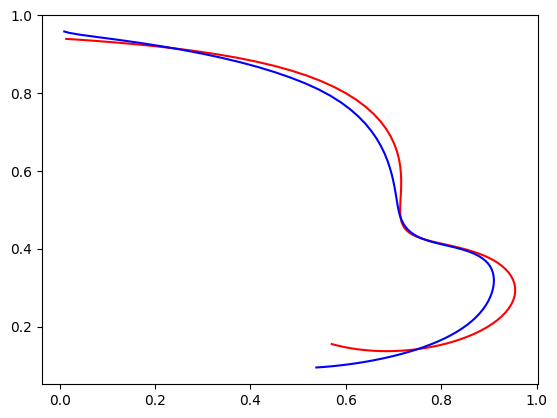

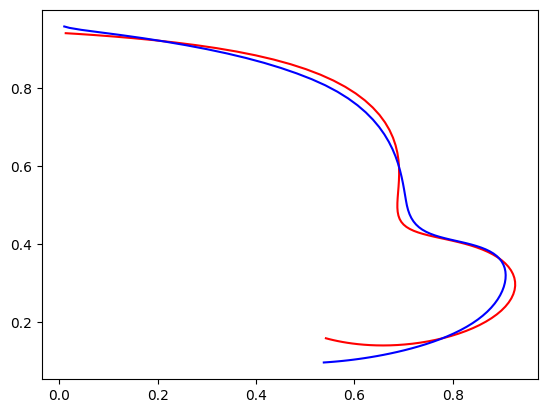

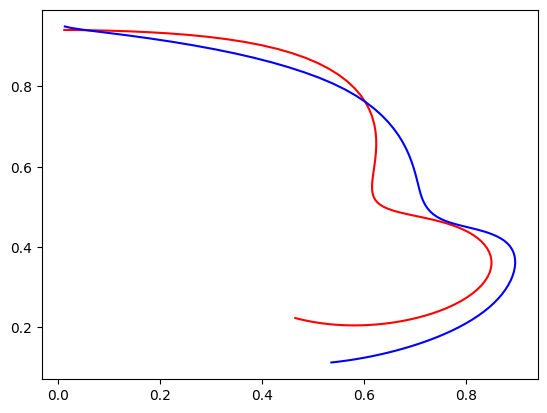

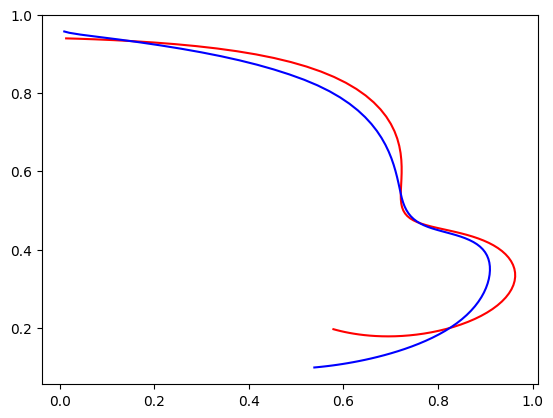

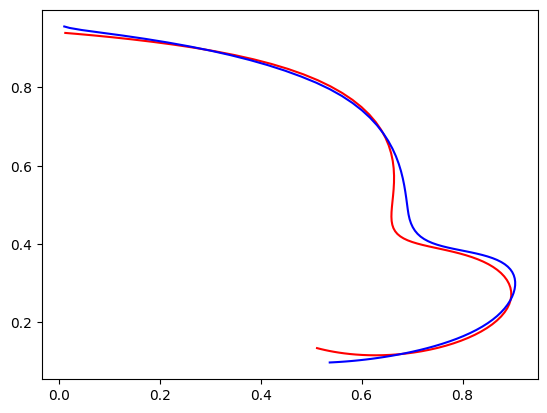

100%|██████████| 157/157 [00:00<00:00, 341.40it/s]


EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 334.47it/s]


EarlyStopping counter: 2 out of 20


100%|██████████| 157/157 [00:00<00:00, 348.70it/s]


EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 354.72it/s]

epoch 10, train loss 0.0000 , time 0.4 sec


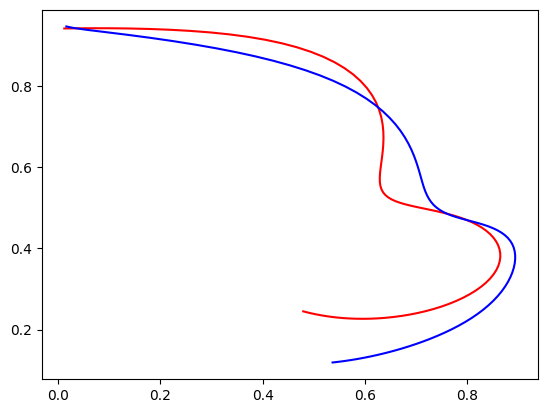

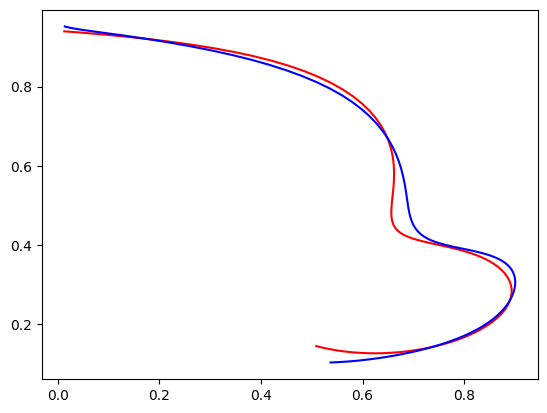

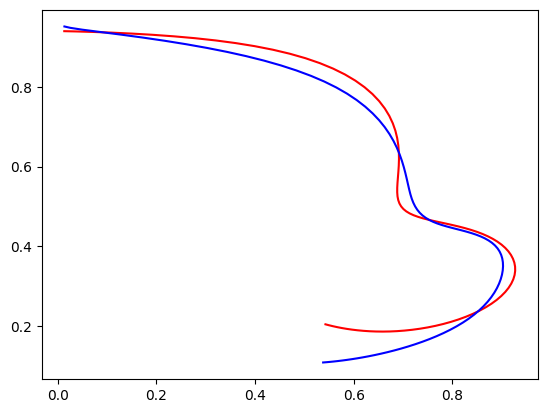

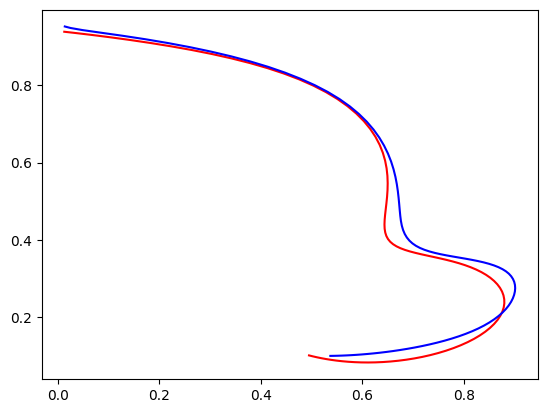

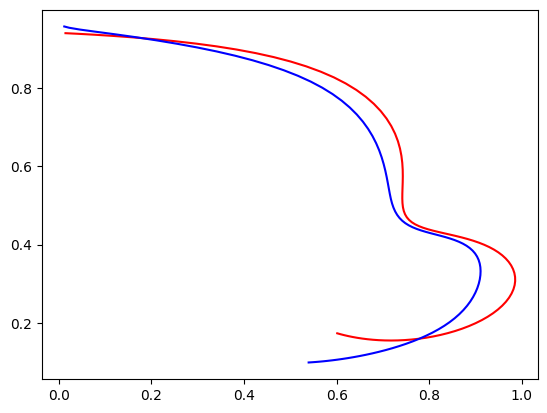

EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 344.60it/s]


EarlyStopping counter: 2 out of 20


100%|██████████| 157/157 [00:00<00:00, 348.58it/s]


EarlyStopping counter: 3 out of 20


100%|██████████| 157/157 [00:00<00:00, 353.80it/s]


EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 333.85it/s]


EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 350.21it/s]


EarlyStopping counter: 2 out of 20


100%|██████████| 157/157 [00:00<00:00, 355.93it/s]


EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 344.98it/s]

epoch 20, train loss 0.0000 , time 0.5 sec


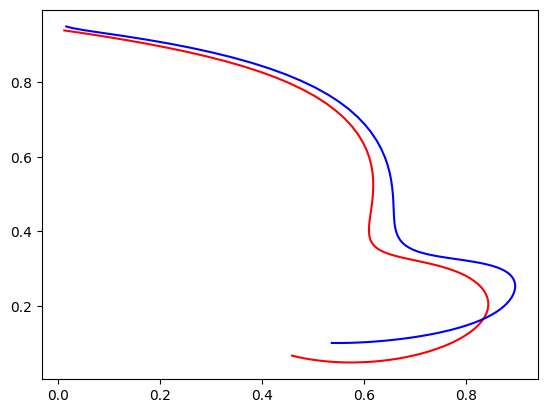

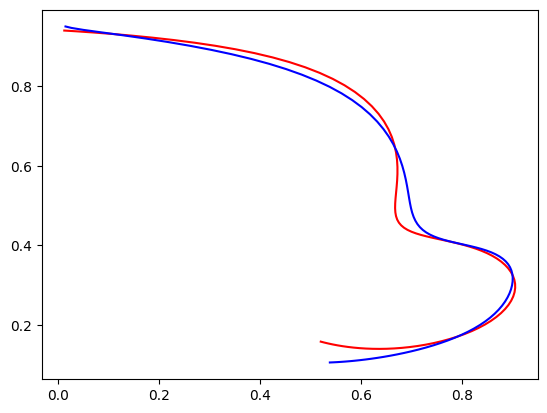

100%|██████████| 157/157 [00:00<00:00, 345.88it/s]


EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 358.35it/s]


EarlyStopping counter: 2 out of 20


100%|██████████| 157/157 [00:00<00:00, 327.81it/s]


EarlyStopping counter: 3 out of 20


100%|██████████| 157/157 [00:00<00:00, 360.74it/s]


EarlyStopping counter: 4 out of 20


100%|██████████| 157/157 [00:00<00:00, 350.08it/s]


EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 327.95it/s]


epoch 30, train loss 0.0000 , time 0.5 sec


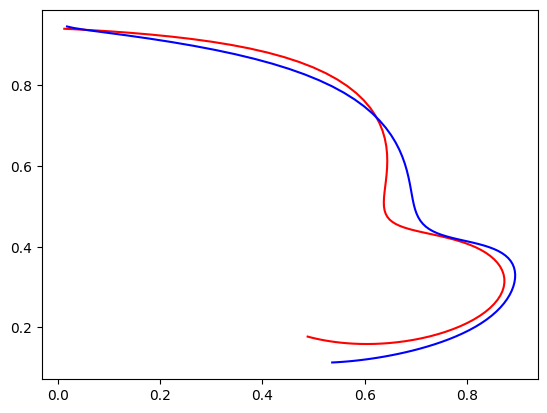

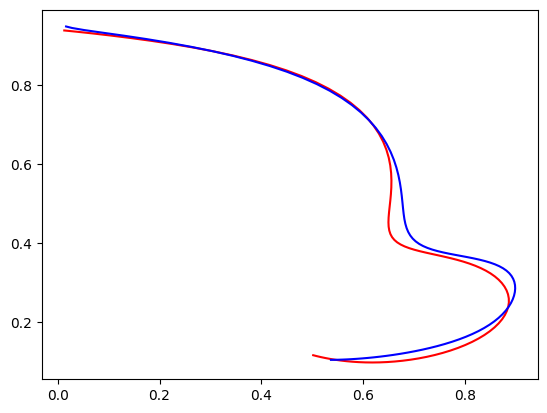

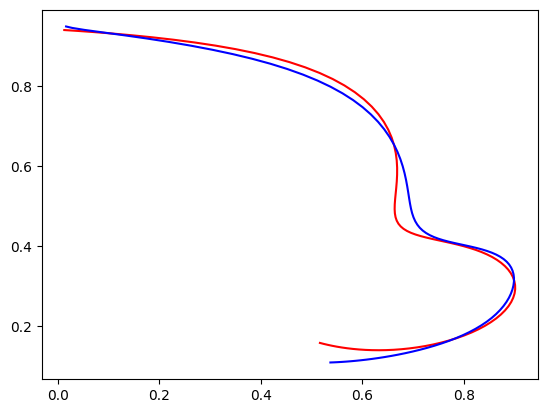

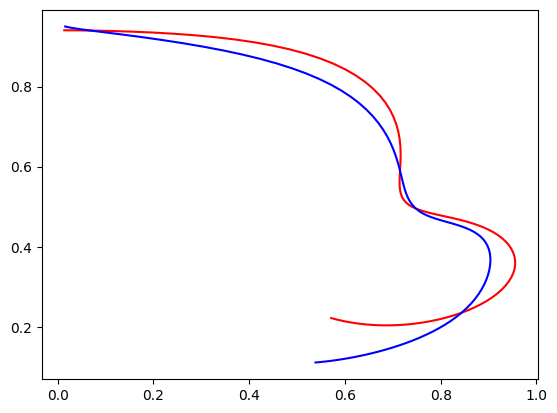

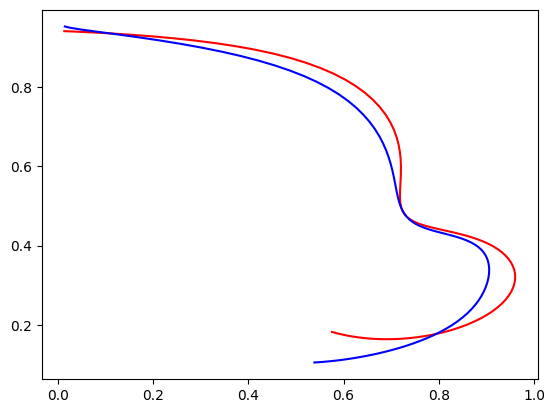

EarlyStopping counter: 2 out of 20


100%|██████████| 157/157 [00:00<00:00, 345.39it/s]


EarlyStopping counter: 3 out of 20


100%|██████████| 157/157 [00:00<00:00, 351.33it/s]


EarlyStopping counter: 4 out of 20


100%|██████████| 157/157 [00:00<00:00, 329.70it/s]


EarlyStopping counter: 5 out of 20


100%|██████████| 157/157 [00:00<00:00, 335.20it/s]


EarlyStopping counter: 6 out of 20


100%|██████████| 157/157 [00:00<00:00, 350.07it/s]


EarlyStopping counter: 7 out of 20


100%|██████████| 157/157 [00:00<00:00, 356.96it/s]


EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 354.36it/s]


EarlyStopping counter: 2 out of 20


100%|██████████| 157/157 [00:00<00:00, 351.36it/s]


EarlyStopping counter: 3 out of 20


100%|██████████| 157/157 [00:00<00:00, 339.11it/s]

epoch 40, train loss 0.0000 , time 0.5 sec


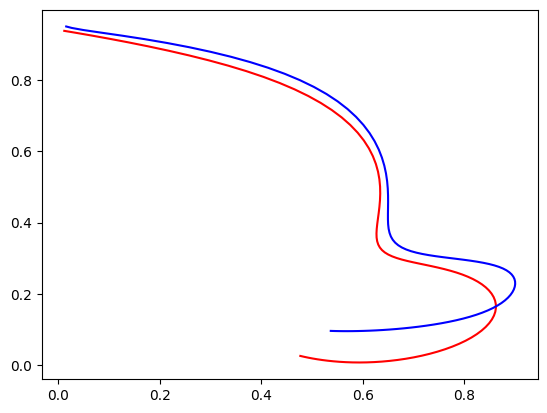

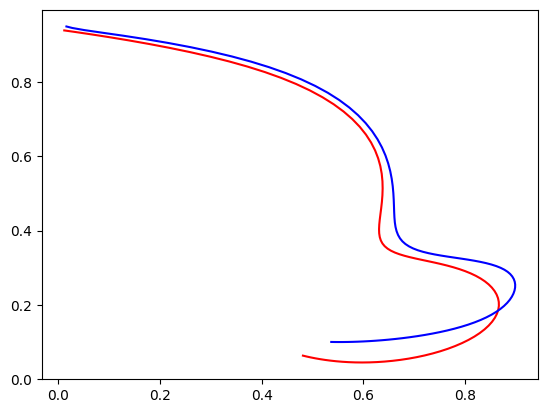

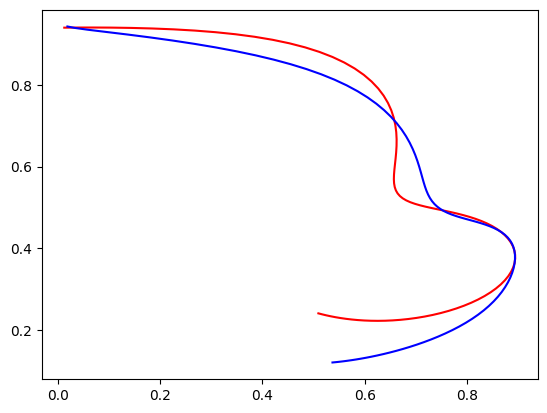

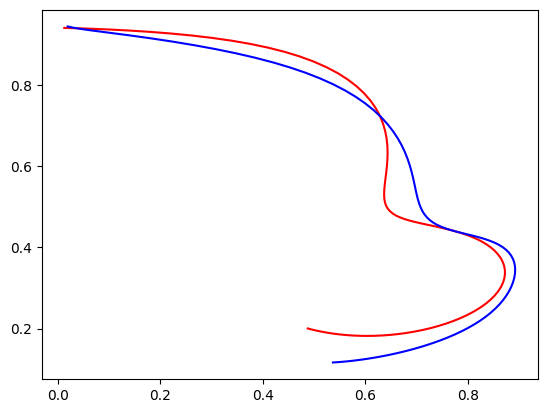

EarlyStopping counter: 4 out of 20


100%|██████████| 157/157 [00:00<00:00, 344.75it/s]


EarlyStopping counter: 5 out of 20


100%|██████████| 157/157 [00:00<00:00, 353.96it/s]


EarlyStopping counter: 6 out of 20


100%|██████████| 157/157 [00:00<00:00, 349.88it/s]


EarlyStopping counter: 7 out of 20


100%|██████████| 157/157 [00:00<00:00, 347.37it/s]


EarlyStopping counter: 8 out of 20


100%|██████████| 157/157 [00:00<00:00, 351.57it/s]


EarlyStopping counter: 9 out of 20


100%|██████████| 157/157 [00:00<00:00, 346.24it/s]


EarlyStopping counter: 10 out of 20


100%|██████████| 157/157 [00:00<00:00, 352.46it/s]


EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 345.23it/s]


EarlyStopping counter: 2 out of 20


100%|██████████| 157/157 [00:00<00:00, 350.00it/s]

epoch 50, train loss 0.0000 , time 0.4 sec


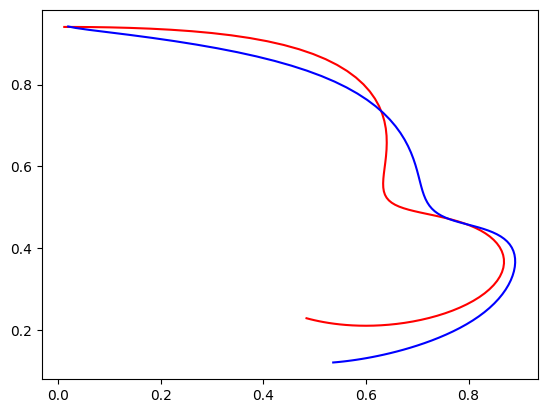

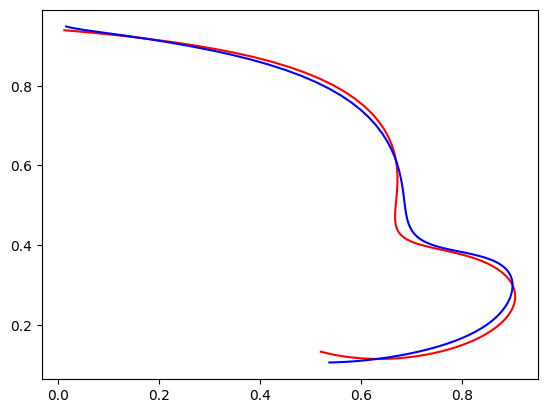

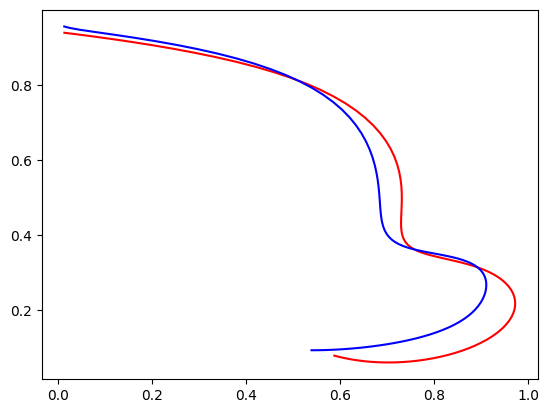

EarlyStopping counter: 3 out of 20


100%|██████████| 157/157 [00:00<00:00, 351.74it/s]


EarlyStopping counter: 4 out of 20


100%|██████████| 157/157 [00:00<00:00, 358.82it/s]


EarlyStopping counter: 5 out of 20


100%|██████████| 157/157 [00:00<00:00, 356.43it/s]


EarlyStopping counter: 6 out of 20


100%|██████████| 157/157 [00:00<00:00, 360.23it/s]


EarlyStopping counter: 7 out of 20


100%|██████████| 157/157 [00:00<00:00, 354.05it/s]


EarlyStopping counter: 8 out of 20


100%|██████████| 157/157 [00:00<00:00, 340.34it/s]


EarlyStopping counter: 9 out of 20


100%|██████████| 157/157 [00:00<00:00, 360.60it/s]


EarlyStopping counter: 10 out of 20


100%|██████████| 157/157 [00:00<00:00, 356.35it/s]


EarlyStopping counter: 11 out of 20


100%|██████████| 157/157 [00:00<00:00, 357.98it/s]


EarlyStopping counter: 12 out of 20


100%|██████████| 157/157 [00:00<00:00, 348.18it/s]

epoch 60, train loss 0.0000 , time 0.5 sec


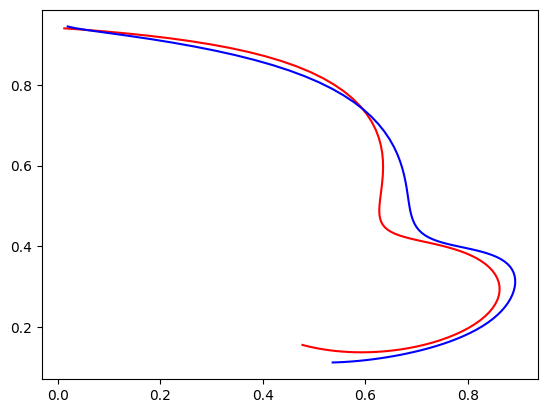

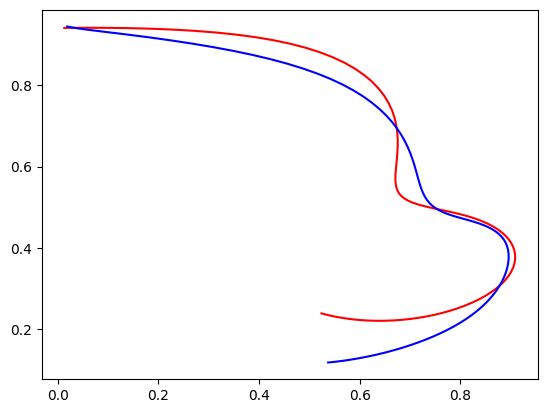

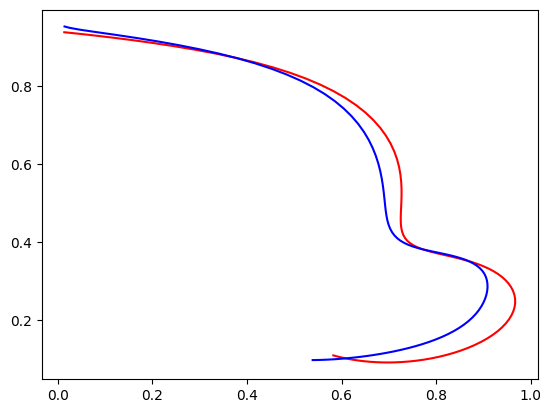

100%|██████████| 157/157 [00:00<00:00, 326.60it/s]


EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 347.10it/s]


EarlyStopping counter: 2 out of 20


100%|██████████| 157/157 [00:00<00:00, 328.31it/s]


EarlyStopping counter: 3 out of 20


100%|██████████| 157/157 [00:00<00:00, 339.17it/s]


EarlyStopping counter: 4 out of 20


100%|██████████| 157/157 [00:00<00:00, 344.59it/s]


EarlyStopping counter: 5 out of 20


100%|██████████| 157/157 [00:00<00:00, 345.93it/s]


EarlyStopping counter: 6 out of 20


100%|██████████| 157/157 [00:00<00:00, 341.64it/s]


EarlyStopping counter: 7 out of 20


100%|██████████| 157/157 [00:00<00:00, 349.53it/s]


EarlyStopping counter: 8 out of 20


100%|██████████| 157/157 [00:00<00:00, 348.25it/s]


EarlyStopping counter: 9 out of 20


100%|██████████| 157/157 [00:00<00:00, 353.14it/s]

epoch 70, train loss 0.0000 , time 0.4 sec


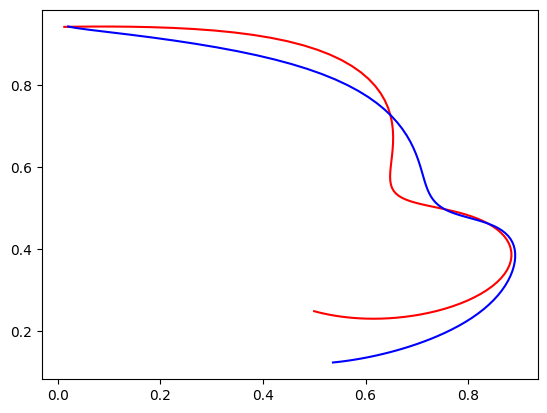

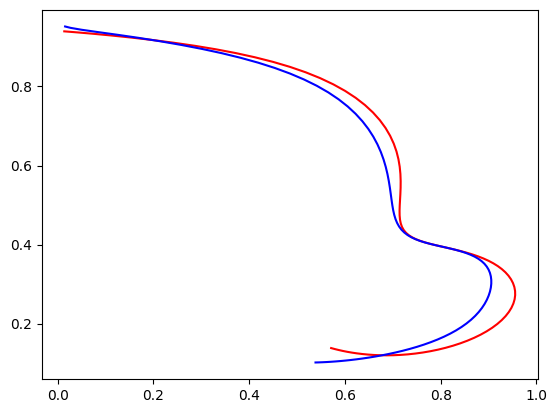

EarlyStopping counter: 10 out of 20


100%|██████████| 157/157 [00:00<00:00, 352.32it/s]


EarlyStopping counter: 11 out of 20


100%|██████████| 157/157 [00:00<00:00, 350.84it/s]


EarlyStopping counter: 12 out of 20


100%|██████████| 157/157 [00:00<00:00, 334.35it/s]


EarlyStopping counter: 13 out of 20


100%|██████████| 157/157 [00:00<00:00, 349.66it/s]


EarlyStopping counter: 1 out of 20


100%|██████████| 157/157 [00:00<00:00, 350.35it/s]


EarlyStopping counter: 2 out of 20


100%|██████████| 157/157 [00:00<00:00, 355.21it/s]


EarlyStopping counter: 3 out of 20


100%|██████████| 157/157 [00:00<00:00, 344.04it/s]


EarlyStopping counter: 4 out of 20


100%|██████████| 157/157 [00:00<00:00, 352.15it/s]


EarlyStopping counter: 5 out of 20


100%|██████████| 157/157 [00:00<00:00, 360.54it/s]

epoch 80, train loss 0.0000 , time 0.4 sec


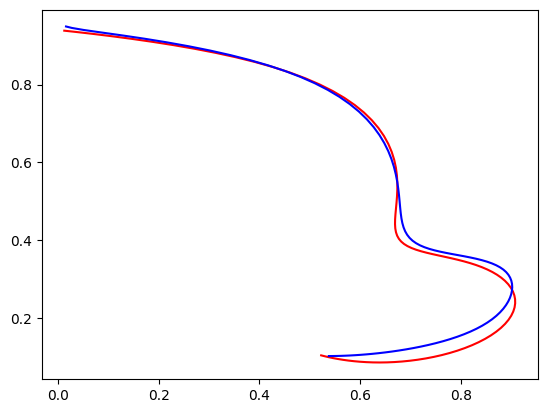

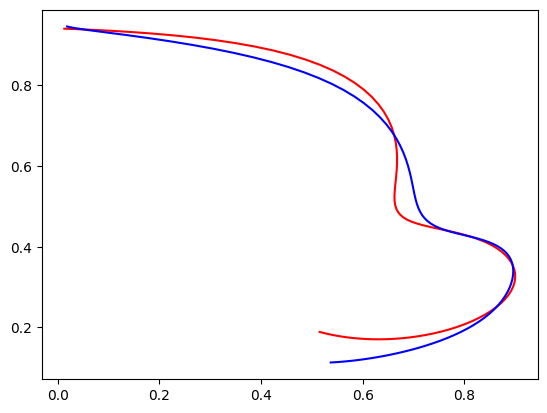

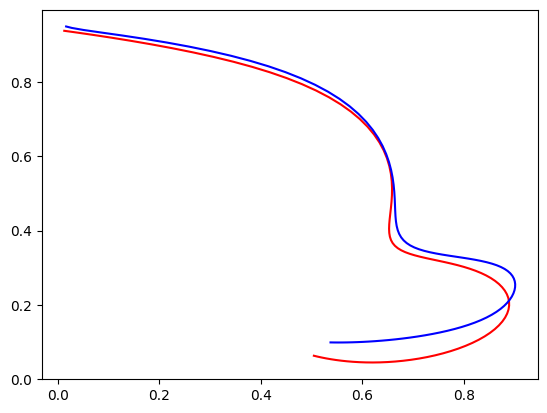

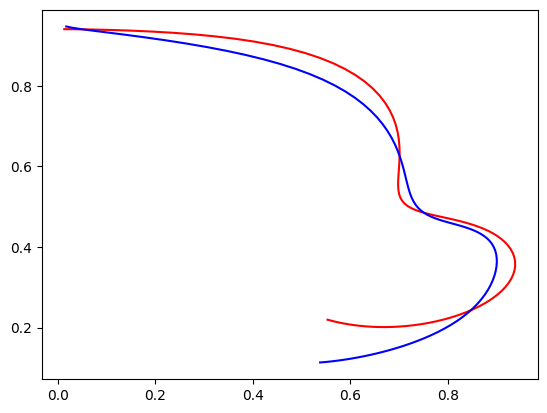

EarlyStopping counter: 6 out of 20


100%|██████████| 157/157 [00:00<00:00, 326.16it/s]


EarlyStopping counter: 7 out of 20


100%|██████████| 157/157 [00:00<00:00, 354.55it/s]


EarlyStopping counter: 8 out of 20


100%|██████████| 157/157 [00:00<00:00, 351.84it/s]


EarlyStopping counter: 9 out of 20


100%|██████████| 157/157 [00:00<00:00, 350.61it/s]


EarlyStopping counter: 10 out of 20


100%|██████████| 157/157 [00:00<00:00, 349.18it/s]


EarlyStopping counter: 11 out of 20


100%|██████████| 157/157 [00:00<00:00, 351.90it/s]


EarlyStopping counter: 12 out of 20


100%|██████████| 157/157 [00:00<00:00, 348.04it/s]


EarlyStopping counter: 13 out of 20


100%|██████████| 157/157 [00:00<00:00, 344.51it/s]


EarlyStopping counter: 14 out of 20


100%|██████████| 157/157 [00:00<00:00, 344.30it/s]


EarlyStopping counter: 15 out of 20


100%|██████████| 157/157 [00:00<00:00, 338.03it/s]

epoch 90, train loss 0.0000 , time 0.5 sec


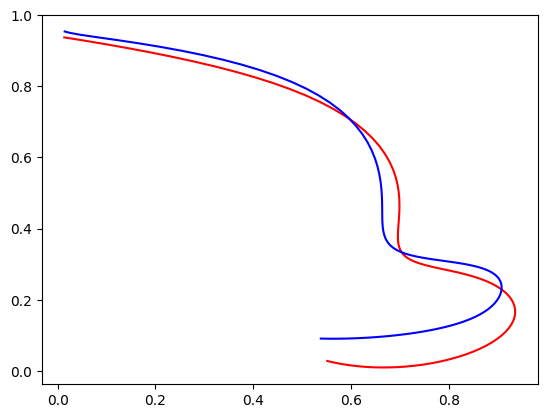

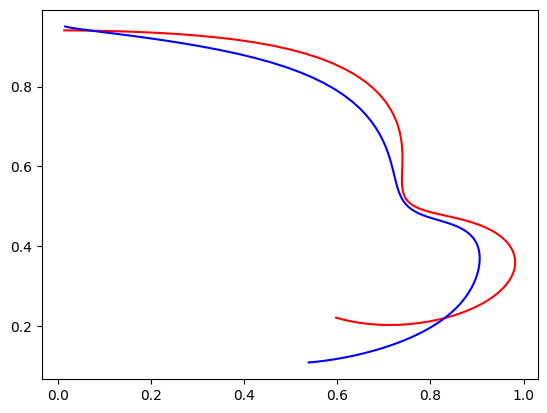

EarlyStopping counter: 16 out of 20


100%|██████████| 157/157 [00:00<00:00, 332.90it/s]


EarlyStopping counter: 17 out of 20


100%|██████████| 157/157 [00:00<00:00, 343.63it/s]


EarlyStopping counter: 18 out of 20


100%|██████████| 157/157 [00:00<00:00, 348.36it/s]


EarlyStopping counter: 19 out of 20


100%|██████████| 157/157 [00:00<00:00, 341.93it/s]

EarlyStopping counter: 20 out of 20


In [92]:
max_epochs = 1000
early_stop = EarlyStop(patience=20, save_name=save_name)

print("training on ", device)
for epoch in range(max_epochs):
    cvae_net.train()
    train_loss, n, start = 0.0, 0, time.time()
    for X, y in tqdm.tqdm(train_iter, ncols=50):
        X = X.to(device)
        y = y.to(device)       
        X_hat, mean, logvar = cvae_net(X, y)

        l = cvae_net.loss(X, X_hat, mean, logvar).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n

    if epoch % 10 == 0:        
        print('epoch %d, train loss %.4f , time %.1f sec'
          % (epoch, train_loss, time.time() - start))

    adjust_lr(optimizer)

    # ------------ plot the training result ------------
    check_number = 2
    if epoch % 10 == 0:
        for i in range(X.shape[0]):
            if y[i][0] == check_number:
                data = X[i, :, :].cpu().numpy()
                data1 = X_hat[i, :, :].detach().cpu().numpy()
                plt.plot(data[0,:], data[1,:], 'r')
                plt.plot(data1[0, :], data1[1, :], 'b')
            plt.show()

    if (early_stop(train_loss, cvae_net, optimizer)):
        break

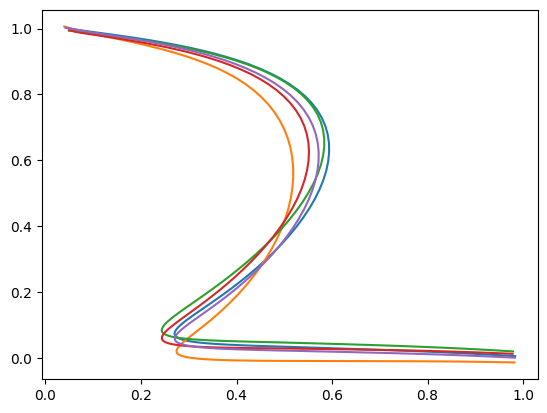

In [ ]:
# generate the data
cvae_net.eval()
# show generated data
start = np.array([0, 1])
ends = np.array([1, 0])
end_range = 0.3
end_offset = 0

test_number = 1
gen_number = 5

errors = []
for i in range(gen_number):
    end = ends + end_range * (np.random.rand(2) - 0.5) + end_offset

    # combine the number and the end position    
    condition = np.concatenate((np.array([test_number]), start, end), dtype=np.float32)   
    data = cvae_net.generate(condition)
    traj = data.detach().cpu().numpy()
    # denormalize the data
    traj = train_dataset.denormalize_data(traj)[0]  
    plt.plot(traj[0, :], traj[1, :])